# Klasyfikacja chorób na zbiorze ChestMnist

## Przygotowanie środowiska

In [89]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from medmnist import ChestMNIST
from torchvision import transforms

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## Przygotowanie danych

In [91]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [92]:
train_ds = ChestMNIST(root='./data', split='train', size=224, transform=train_transform, download=True)
validation_ds = ChestMNIST(root='./data', split='val', size=224, transform=val_test_transform, download=True)
test_ds = ChestMNIST(root='./data', split='test', size=224, transform=val_test_transform, download=True)

In [93]:
CLASS_NAMES = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

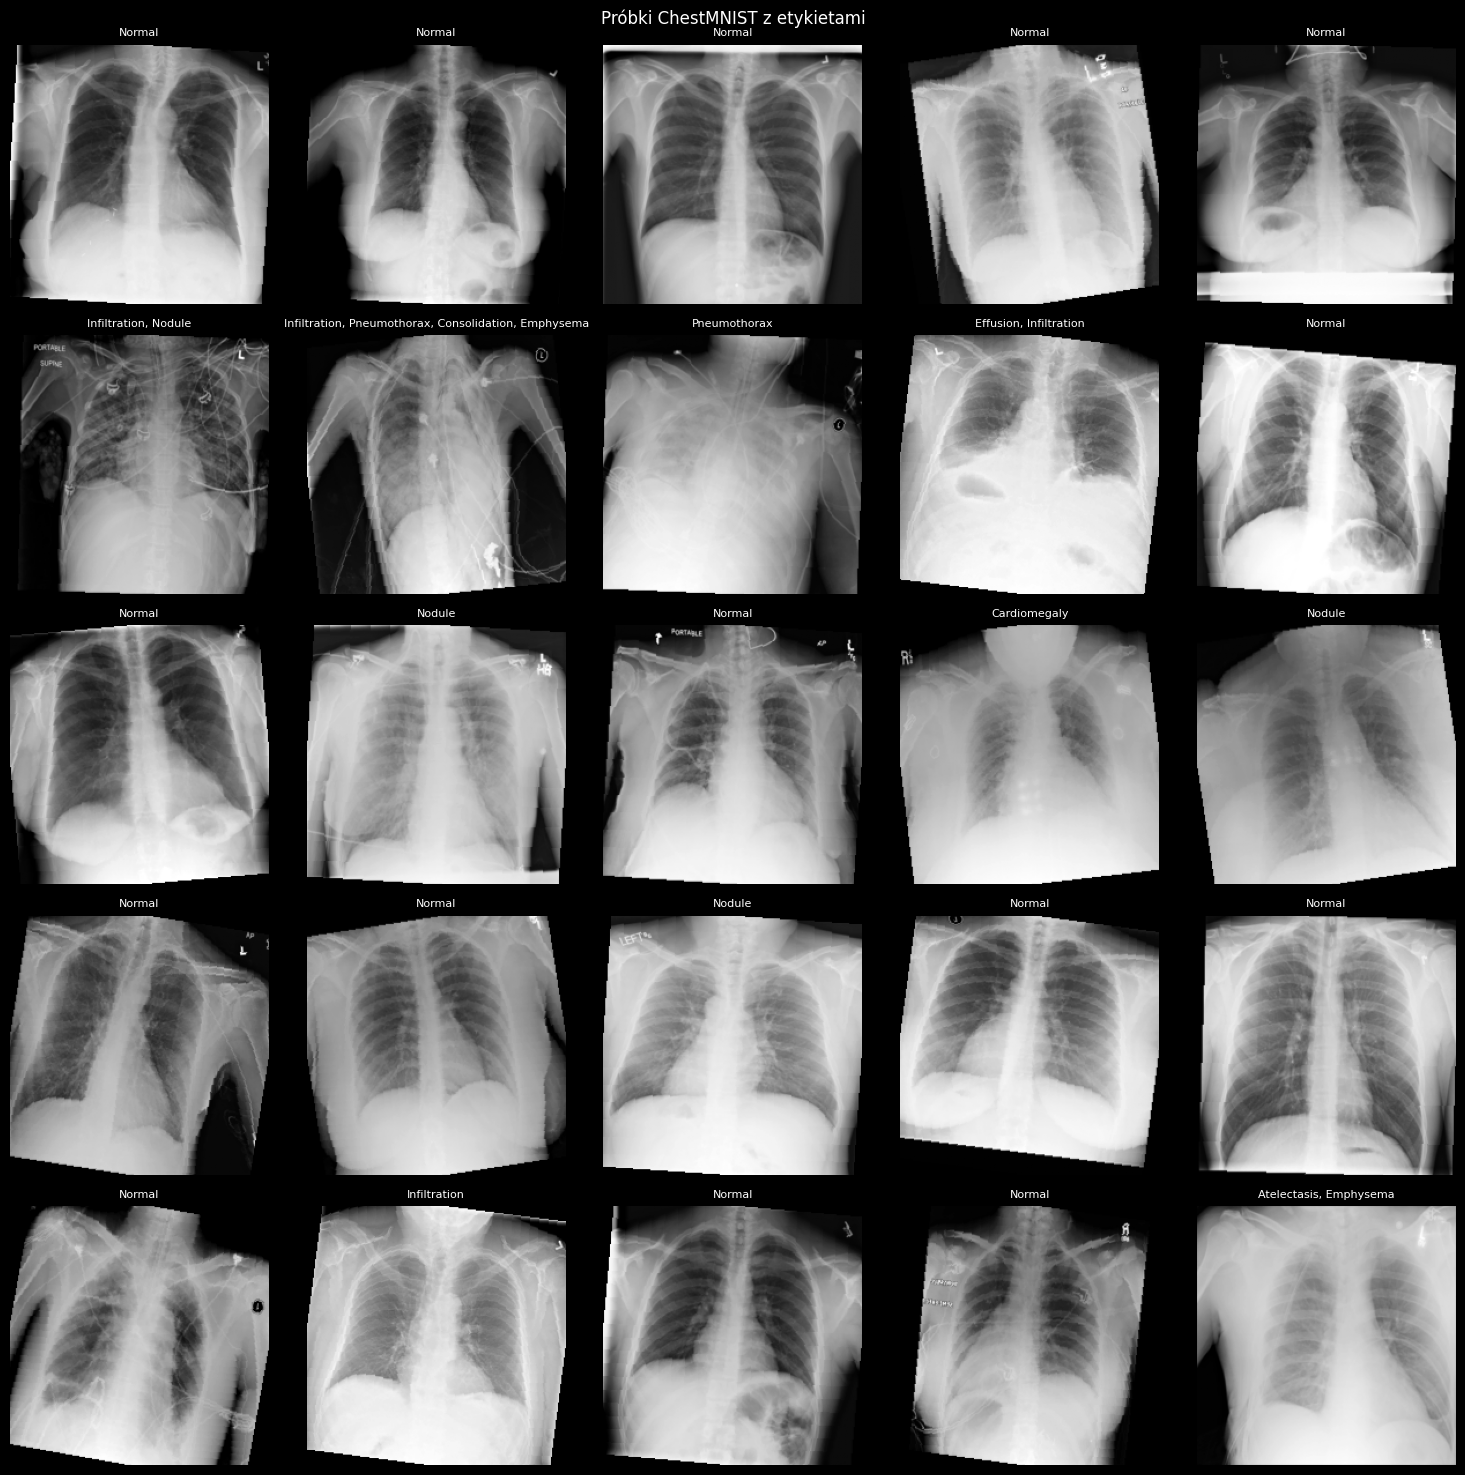

In [94]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    img, label = train_ds[i]

    if img.ndim == 3:
        img = img.squeeze(0)

    active_classes = [
        CLASS_NAMES[j] for j, v in enumerate(label) if v == 1
    ]

    title = ", ".join(active_classes) if active_classes else "Normal"

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(title, fontsize=8)
    axes[i].axis("off")

plt.suptitle("Próbki ChestMNIST z etykietami", fontsize=12)
plt.tight_layout()
plt.show()

In [95]:
train_labels = train_ds.labels
class_counts = np.sum(train_labels, axis=0)
class_weights = 1.0 / class_counts

sample_weights = []

for label in train_labels:
    active_indices = np.where(label == 1)[0]

    if len(active_indices) > 0:
        weight = np.max(class_weights[active_indices])
    else:
        weight = np.mean(class_weights)

    sample_weights.append(weight)

sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds), replacement=True)

In [96]:
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    validation_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/tmp/ipykernel_30034/4282419871.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


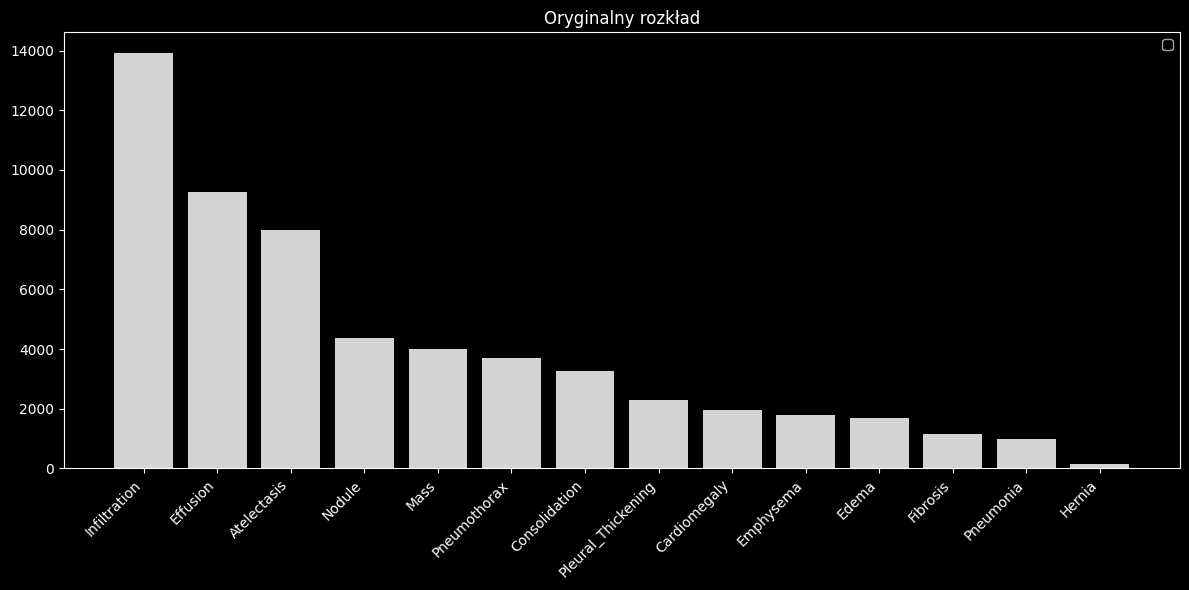

In [97]:
def analyze_class_counts(dataset, class_names):
    all_labels = dataset.labels
    class_counts = np.sum(all_labels, axis=0)
    df = pd.DataFrame({
        "Klasa": class_names,
        "Liczba próbek": class_counts.astype(int),
        "Udział %": (class_counts / len(dataset) * 100).round(2)
    })
    df = df.sort_values(by="Liczba próbek", ascending=False)
    return df

df_train = analyze_class_counts(train_ds, CLASS_NAMES)

plt.figure(figsize=(12, 6))
plt.bar(df_train["Klasa"], df_train["Liczba próbek"], color='lightgray')
plt.title("Oryginalny rozkład")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

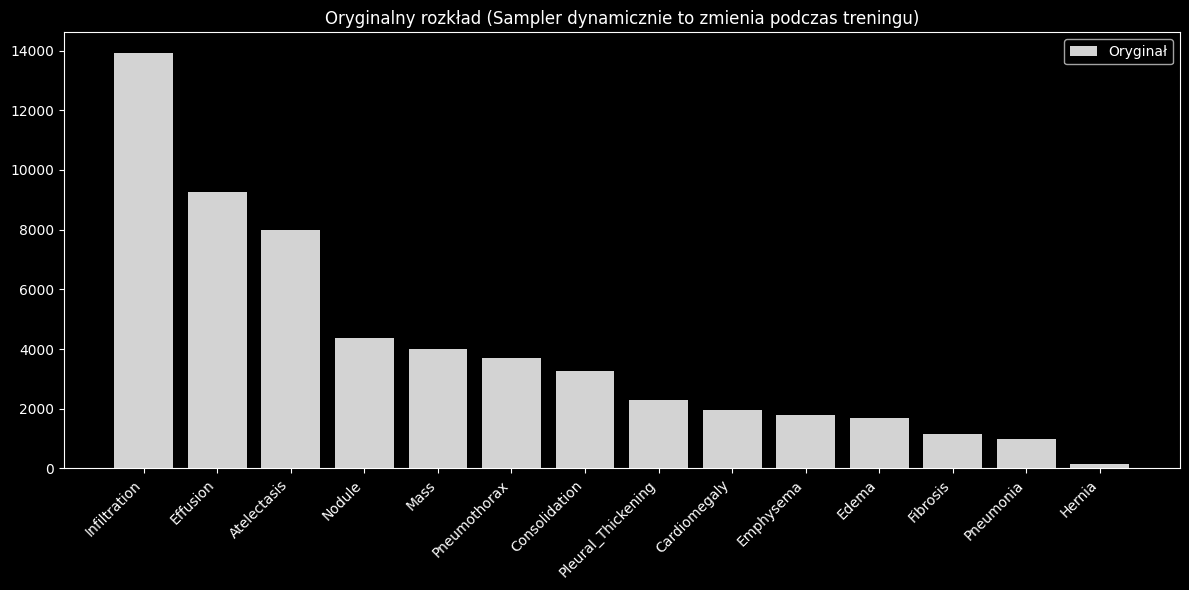

In [35]:
def analyze_class_counts(dataset, class_names):
    all_labels = dataset.labels
    class_counts = np.sum(all_labels, axis=0)
    df = pd.DataFrame({
        "Klasa": class_names,
        "Liczba próbek": class_counts.astype(int),
        "Udział %": (class_counts / len(dataset) * 100).round(2)
    })
    df = df.sort_values(by="Liczba próbek", ascending=False)
    return df

df_train = analyze_class_counts(train_ds, CLASS_NAMES)

plt.figure(figsize=(12, 6))
plt.bar(df_train["Klasa"], df_train["Liczba próbek"], color='lightgray', label='Oryginał')
plt.title("Oryginalny rozkład (Sampler dynamicznie to zmienia podczas treningu)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Trenowanie modelu

### Model konwolucyjnej sieci neuronowej

In [99]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):    
        super().__init__()
        
        padding = kernel_size // 2

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

    def forward(self, x):
        return self.block(x)

In [100]:
class CNN(nn.Module):                                             
    def __init__(self, in_channels=1, num_labels=14):
        super().__init__()

        self.features = nn.Sequential(
            ConvBlock(in_channels, 32, kernel_size=7),   
            ConvBlock(32, 64, kernel_size=5),             
            ConvBlock(64, 128, kernel_size=5),            
            ConvBlock(128, 256, kernel_size=3),           
            ConvBlock(256, 512, kernel_size=3),           
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_labels)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [101]:
def train_step(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)         

        optimizer.zero_grad()
        outputs = model(inputs)                     
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    epoch_loss = sum(total_loss) / len(total_loss)

    return epoch_loss

In [102]:
from sklearn.metrics import roc_auc_score, accuracy_score 

def get_auc(labels, preds):
    auc = 0
    for i in range(labels.shape[1]):
        auc += roc_auc_score(labels[:, i], preds[:, i])
    
    return auc / preds.shape[1]

def get_acc(labels, preds, threshold=0.5):
    acc = 0.0 

    one_zero_preds = (preds > threshold).astype(int)
    for label in range(preds.shape[1]):
        acc += accuracy_score(labels[:, label], one_zero_preds[:, label])

    return acc / preds.shape[1]

In [103]:
import numpy as np

@torch.no_grad()
def validate(model, dataloader, criterion, device, is_eval=False):
    model.eval()
    total_loss = []
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        outputs = model(inputs.to(device))

        loss = criterion(outputs, labels)

        preds = torch.sigmoid(outputs)

        total_loss.append(loss.item())
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    val_loss = np.mean(total_loss)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    auc = get_auc(all_labels, all_preds)
    acc = get_acc(all_labels, all_preds)

    return val_loss, auc, acc, all_preds

In [104]:
model = CNN().to(device)

In [105]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [106]:
N_EPOCHS = 8

train_losses = []
val_losses = []
val_accs = []
val_aucs = []

for epoch in range(N_EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, device)
    val_loss, val_auc, val_acc, _  = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)

    print(
        f"Epoch [{epoch+1}/{N_EPOCHS}], " 
        f"train loss: {train_loss:.4f}, "
        f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val auc: {val_auc:.4f}"
    )

Epoch [1/8], train loss: 0.1278, val loss: 0.1967, val acc: 0.9492, val auc: 0.6460


KeyboardInterrupt: 

In [ ]:
epochs = range(1, N_EPOCHS + 1)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Funkcja straty na danych treningowych")
plt.plot(epochs, val_losses, label="Funkcja straty na danych walidacyjnych")
plt.xlabel("Epoka")
plt.ylabel("Błąd")
plt.title("Funkcja straty w zależności od epoki")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, label="Dokładność na danych walidacyjnych")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.title("Dokładność w zależności od epoki")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_aucs, label="AUC na danych walidacyjnych")
plt.xlabel("Epoka")
plt.ylabel("AUC")
plt.title("AUC w zależności od epoki")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = CNN()
model = model.to(device)

model_state = torch.load("models/first_model.pth", map_location=device)

model.load_state_dict(model_state)
model.eval()

In [ ]:
_, auc, acc, y_preds = validate(model, test_loader, criterion, device)

print(f"Test AUC: {auc:6f}")
print(f"Test ACC: {acc:6f}")

In [ ]:
y_true = test_ds.labels
y_pred_binary = (y_preds > 0.5).astype(int)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_score, average='samples', zero_division=1)

print(f"Precision: {precision:6f}")
print(f"Recall: {recall:6f}")
print(f"F1: {f1:6f}")

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_score, average='samples', zero_division=1)

print(f"Precision: {precision:6f}")
print(f"Recall: {recall:6f}")
print(f"F1: {f1:6f}")

In [ ]:
print(classification_report(y_true, y_pred_binary, target_names=CLASS_NAMES, zero_division=0))

In [ ]:
for i in range(y_score.shape[1]):
    fig, ax = plt.subplots(figsize=(4, 4))

    ConfusionMatrixDisplay.from_predictions(
        y_true[:, i],
        y_pred_binary[:, i],
        display_labels=["Zdrowy", CLASS_NAMES[i]],
        cmap='Blues',
        ax=ax,
        colorbar=False
    )

    ax.set_title(f"Macierz: {CLASS_NAMES[i]}")
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(y_score.shape[1]):
    ConfusionMatrixDisplay.from_predictions(
        y_true[:, i], 
        y_score[:, i], 
        display_labels=["No " + CLASS_NAMES[i], CLASS_NAMES[i]], 
        cmap='Blues'
    )

## Optymalizacja z Optuna

In [ ]:
def get_dataloarders(batch_size):
    DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        validation_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader

In [ ]:
def get_dataloarders(batch_size):
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        validation_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader

In [ ]:
import optuna

N_BLOCKS = 5
CHANNELS = [16, 32]
GROWTH_FACTOR = 2
BATCH_SIZES = [16, 32, 64]

class DynamicCNN(nn.Module):
    def __init__(self, in_channels, num_classes, trial):
        super().__init__()

        base_channels = trial.suggest_categorical("base_channels", CHANNELS)

        layers = []
        in_ch = in_channels

        for i in range(N_BLOCKS):
            out_ch = base_channels * (GROWTH_FACTOR ** i)

            if i == 0:
                KERNEL_SIZES = [3, 5, 7]
            elif i <= 2:
                KERNEL_SIZES = [3, 5]
            else:
                KERNEL_SIZES = [3]

            kernel_size = trial.suggest_categorical(f"kernel_size_block_{i}", KERNEL_SIZES)

            layers.append(ConvBlock(in_ch, out_ch, kernel_size))
            in_ch = out_ch

        self.features = nn.Sequential(*layers)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.clf = nn.Linear(in_ch, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.clf(x)

In [ ]:
def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", BATCH_SIZES)

    train_loader, val_loader = get_dataloarders(batch_size)

    model = DynamicCNN(
        in_channels=1, 
        num_classes=14, 
        trial=trial
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_auc = 0.0
    epochs = 10

    for epoch in range(epochs):
        _ = train_step(model, train_loader, optimizer, criterion, device)
        _, val_auc, _  = validate(model, val_loader, criterion, device)

        trial.report(val_auc, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        best_auc = max(best_auc, val_auc)

    return best_auc
        

In [ ]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)

study.optimize(objective, n_trials=50)

print("Best AUC:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")